In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import nnde
from mpl_toolkits.mplot3d import Axes3D
np.seterr(all='raise')
import pixiedust

Pixiedust database opened successfully


In [2]:
n_samples = 10
X_p = np.linspace(0, 1, n_samples)
Y_p = np.linspace(0, 1, n_samples)
X_p, Y_p = np.meshgrid(X_p, Y_p)
X_p = X_p.flatten()
Y_p = Y_p.flatten()
samples = np.array([X_p, Y_p]).T

## Example A: 1d string with fixed ends

$$\frac{\partial^2 u}{\partial t^2}=c^2\frac{\partial^2 u}{\partial x^2}$$

With boundary conditions $u(0,t)=0$, $u(1, t)=0$, $u(x, 0)=\sin(\pi x)$, and $\frac{\partial u}{\partial t}(x, 0)=0$.

The trial solution for this case is $u(x, y)=A(x, y) + B(x, y)(N(x, y)-N(x,0)-\frac{\partial N}{\partial t}(x, 0))$ with $B(x)=x(1-x)t$ and $$A(x, y)=\sin(\pi x).$$

In [3]:
c = 2

In [4]:
def exampleA_boundary_value(point):
  return np.sin(np.pi * point[0])

In [5]:
def exampleA_boundary_vanishing(point):
  x = point[0]
  t = point[1]
  return x * (1 - x) * t

### Defining the loss function for a single point and a whole set

The loss function is based on the formula:
$$Loss(N)=\sum_i \left(\frac{\partial^2 u}{\partial t^2}-c^2\frac{\partial^2 u}{\partial x^2}\right)^2$$
And the Laplace operator term acting on the trial solution becomes:
$$\frac{\partial^2 u}{\partial t^2}-c^2\frac{\partial^2 u}{\partial x^2}=\frac{\partial^2 A(x,y)}{\partial t^2} -c^2 \frac{\partial^2 A(x,y)}{\partial x^2}  + \left(\frac{\partial^2}{\partial t^2}-c^2 \frac{\partial^2}{\partial x^2}\right)(x(1-x)t\left[N(x,t)-N(x,1)-\dot{N}(x,1)\right])$$
$$=c^2\pi^2\sin(\pi x) + 2x(1-x)\dot{N}(x,t) + x(1-x)t\ddot{N}(x,t) +2c^2t\left[N(x,t)-N(x,1)-\dot{N}(x,1)\right]$$
$$-2c^2(1-2x)t\left[N'(x,t)-N'(x,1)-\dot{N}'(x,1)\right]  -c^2x(1-x)t\left[N''(x,t)-N''(x,1)-\dot{N}''(x,1)\right]$$

In [6]:
def exampleA_loss_function_single_point(self, point, non_squared=False, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  t = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  
  N = self.forward_pass(point, 0)
  dN = self.forward_pass(point, 1)
  d2N = self.forward_pass(point, 2)
  
  N1 = self.forward_pass(np.array([x, 1]), 0)
  dN1 = self.forward_pass(np.array([x, 1]), 1)
  d2N1 = self.forward_pass(np.array([x, 1]), 2)
  
  dxdtN1 = self.forward_pass_arbitrary_derivative(np.array([x, 1]), np.array([1, 1]))
  dx2dtN1 = self.forward_pass_arbitrary_derivative(np.array([x, 1]), np.array([2, 1]))
  
  loss = ( c**2*np.pi**2 *np.sin(np.pi * x) +2*x*(1-x)*dN[0, 1] + x*(1-x)*t*d2N[0, 1] +2*c**2*t*(N[0]-N1[0]-dN1[0, 1])
          -2*c**2*t*(1-2*x)*(dN[0, 0] - dN1[0, 0] - dxdtN1[0]) -c**2*x*(1-x)*t*(d2N[0, 0] - d2N1[0, 0] - dx2dtN1[0])
    )
  if not non_squared:
    loss = loss ** 2
  return loss[0]

In [7]:
def exampleA_loss_function(self, samples, *kwargs):
  loss = 0
  for i in range(samples.shape[0]):
    loss += self.loss_function_single_point(self, samples[i])
  return loss/samples.shape[0]

### Defining the update rules

The following functions represent $\frac{\partial Loss}{\partial \vec{b}}$, $\frac{\partial Loss}{\partial H}$, and $\frac{\partial Loss}{\partial V}$

In [8]:
def exampleA_bias_change(self, point, label, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  t = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  
  db_N = self.network_derivative_bias(point, 0)
  db_DN = self.network_derivative_bias(point, 1)
  db_D2N = self.network_derivative_bias(point, 2)
  
  db_N1 = self.network_derivative_bias(np.array([x, 1]), 0)
  db_DN1 = self.network_derivative_bias(np.array([x, 1]), 1)
  db_D2N1 = self.network_derivative_bias(np.array([x, 1]), 2)
  
  db_dxdtN1 = self.arbitrary_network_derivative_bias(np.array([x, 1]), np.array([1, 1]))
  db_dx2dtN1 = self.arbitrary_network_derivative_bias(np.array([x, 1]), np.array([2, 1]))

  db = np.zeros((self.hidden_dim, 1)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  
  for m in range(self.hidden_dim):
    db[m] += 2 * loss_sqrt * ( 
      2*x*(1-x)*db_DN[0, 1, m] + x*(1-x)*t*db_D2N[0, 1, m] +2*c**2*t*(db_N[0, 0, m]-db_N1[0, 0, m]-db_DN1[0, 1, m])
          -2*c**2*t*(1-2*x)*(db_DN[0, 0, m] - db_DN1[0, 0, m] - db_dxdtN1[0, m]) -c**2*x*(1-x)*t*(db_D2N[0, 0, m]
          - db_D2N1[0, 0, m] - db_dx2dtN1[0, m])
      )
  return db

In [9]:
def exampleA_hidden_weights_change(self, point, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  t = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  
  dH_N = self.network_derivative_hidden_weights(point, 0)
  dH_DN = self.network_derivative_hidden_weights(point, 1)
  dH_D2N = self.network_derivative_hidden_weights(point, 2)
  
  dH_N1 = self.network_derivative_hidden_weights(np.array([x, 1]), 0)
  dH_DN1 = self.network_derivative_hidden_weights(np.array([x, 1]), 1)
  dH_D2N1 = self.network_derivative_hidden_weights(np.array([x, 1]), 2)
  
  dH_dxdtN1 = self.arbitrary_network_derivative_hidden_weights(np.array([x, 1]), np.array([1, 1]))
  dH_dx2dtN1 = self.arbitrary_network_derivative_hidden_weights(np.array([x, 1]), np.array([2, 1]))

  dH = np.zeros((self.hidden_dim, self.input_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  for m in range(self.hidden_dim):
    for p in range(self.input_dim):
      dH[m, p] += 2 * loss_sqrt * ( 
      2*x*(1-x)*dH_DN[0, 1, m, p] + x*(1-x)*t*dH_D2N[0, 1, m, p] +2*c**2*t*(dH_N[0, 0, m, p]-dH_N1[0, 0, m, p]-dH_DN1[0, 1, m, p])
          -2*c**2*t*(1-2*x)*(dH_DN[0, 0, m, p] - dH_DN1[0, 0, m, p] - dH_dxdtN1[0, m, p]) -c**2*x*(1-x)*t*(dH_D2N[0, 0, m, p]
          - dH_D2N1[0, 0, m, p] - dH_dx2dtN1[0, m, p])
      )
  return dH

In [10]:
def exampleA_visible_weights_change(self, point, *kwargs):
  x = point[0][0] if isinstance(point[0], np.ndarray) else point[0]
  t = point[1][0] if isinstance(point[1], np.ndarray) else point[0]
  
  dV_N = self.network_derivative_visible_weights(point, 0)
  dV_DN = self.network_derivative_visible_weights(point, 1)
  dV_D2N = self.network_derivative_visible_weights(point, 2)
  
  dV_N1 = self.network_derivative_visible_weights(np.array([x, 1]), 0)
  dV_DN1 = self.network_derivative_visible_weights(np.array([x, 1]), 1)
  dV_D2N1 = self.network_derivative_visible_weights(np.array([x, 1]), 2)
  
  dV_dxdtN1 = self.arbitrary_network_derivative_visible_weights(np.array([x, 1]), np.array([1, 1]))
  dV_dx2dtN1 = self.arbitrary_network_derivative_visible_weights(np.array([x, 1]), np.array([2, 1]))

  dV = np.zeros((self.visible_dim, self.hidden_dim)).astype(dtype="float64")
  loss_sqrt = self.loss_function_single_point(self, point, non_squared=True)
  for m in range(self.visible_dim):
    for p in range(self.hidden_dim):
      dV[m, p] += 2 * loss_sqrt * ( 
      2*x*(1-x)*dV_DN[0, 1, m, p] + x*(1-x)*t*dV_D2N[0, 1, m, p] +2*c**2*t*(dV_N[0, 0, m, p]-dV_N1[0, 0, m, p]-dV_DN1[0, 1, m, p])
          -2*c**2*t*(1-2*x)*(dV_DN[0, 0, m, p] - dV_DN1[0, 0, m, p] - dV_dxdtN1[0, m, p]) -c**2*x*(1-x)*t*(dV_D2N[0, 0, m, p]
          - dV_D2N1[0, 0, m, p] - dV_dx2dtN1[0, m, p])
      )
  return dV

### Defining the trial solution with an apropiate network

In [17]:
exampleA_trial_solution = nnde.TrialSolution(loss_function=exampleA_loss_function,
                                        loss_function_single_point=exampleA_loss_function_single_point,
                                        bias_change=exampleA_bias_change,
                                        hidden_weights_change=exampleA_hidden_weights_change,
                                        visible_weights_change=exampleA_visible_weights_change,
                                        boundary_condition_value_function=exampleA_boundary_value,
                                        boundary_vanishing_function=exampleA_boundary_vanishing,
                                        input_dim=2, hidden_dim=10, output_dim=1, learning_rate=0.001, momentum=0)

### Training for 5000 epochs

In [18]:
exampleA_trial_solution.train(samples, int(1000))

Epoch: 1 Loss function: 422.98143377138126
Epoch: 2 Loss function: 116.93269987581633
Epoch: 3 Loss function: 131.53871855304445
Epoch: 4 Loss function: 130.41986572599097
Epoch: 5 Loss function: 74.58063252161432
Epoch: 6 Loss function: 80.38336267459793
Epoch: 7 Loss function: 102.6922810007657
Epoch: 8 Loss function: 125.80804046240212
Epoch: 9 Loss function: 141.41506381128477
Epoch: 10 Loss function: 77.51455953111365
Epoch: 11 Loss function: 71.15487932075466
Epoch: 12 Loss function: 145.00287759901175
Epoch: 13 Loss function: 210.38934828782646
Epoch: 14 Loss function: 84.72818825075414
Epoch: 15 Loss function: 128.74947234333004
Epoch: 16 Loss function: 191.62241574884095
Epoch: 17 Loss function: 138.30218178177896
Epoch: 18 Loss function: 112.34622359055678
Epoch: 19 Loss function: 113.89145415467063
Epoch: 20 Loss function: 171.9181041153122
Epoch: 21 Loss function: 180.38887428490656
Epoch: 22 Loss function: 189.24580022214388
Epoch: 23 Loss function: 239.2886573312507
Epoch

Epoch: 188 Loss function: 182.8547043426638
Epoch: 189 Loss function: 254.53838943504326
Epoch: 190 Loss function: 247.82868983658528
Epoch: 191 Loss function: 174.66298682409194
Epoch: 192 Loss function: 175.1558746541333
Epoch: 193 Loss function: 197.84160352558013
Epoch: 194 Loss function: 218.58886832813172
Epoch: 195 Loss function: 226.2225095351522
Epoch: 196 Loss function: 170.13377914521797
Epoch: 197 Loss function: 222.85553094781835
Epoch: 198 Loss function: 207.0735311812862
Epoch: 199 Loss function: 280.6569980106754
Epoch: 200 Loss function: 267.2677510625175
Epoch: 201 Loss function: 200.42465407169806
Epoch: 202 Loss function: 207.45148976643154
Epoch: 203 Loss function: 195.72052088199538
Epoch: 204 Loss function: 182.31349455490187
Epoch: 205 Loss function: 253.5814096748085
Epoch: 206 Loss function: 196.37682207505046
Epoch: 207 Loss function: 218.00719417686514
Epoch: 208 Loss function: 280.7807390344178
Epoch: 209 Loss function: 196.43070296397258
Epoch: 210 Loss fu

KeyboardInterrupt: 

### Plotting the results 

The numerical solution (training set - red, valdiaiton set - green) along with the analytical solution (blue).

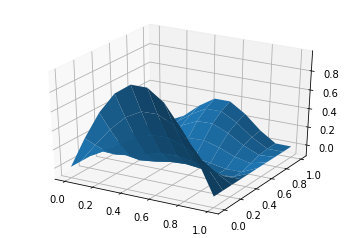

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
new_shape = int(np.sqrt(samples.shape[0]))
ZeAsol = np.array([exampleA_trial_solution.predict(samples[i]) for i in range(samples.shape[0])]).reshape((samples.shape[0],))
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=ZeAsol.reshape((new_shape, new_shape)), label='Numerical - Training')
# ax.scatter3D(xs=samples[:,0], ys=samples[:,1], zs=ZeAsol, label='Numerical - Training')
# plt.legend()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ZeAanal = (samples[:,0] + samples[:,1]**3) * np.exp(-samples[:, 0])
ZeAdiff = ZeAsol - ZeAanal
ax.plot_surface(X=samples[:,0].reshape((new_shape, new_shape)), Y=samples[:,1].reshape((new_shape, new_shape)), Z=ZeAanal.reshape((new_shape, new_shape)), label='Analytic')
# plt.legend()
plt.show()

In [ ]:
ZeAdiff.max()